In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import tensorflow as tf
import math

In [3]:
### read data 
train = pd.read_csv("~/Documents/Data/MNIST/mnist_train.csv")
test = pd.read_csv("~/Documents/Data/MNIST/mnist_test.csv")

In [4]:
#### data size
print("training set shape: {}".format(train.shape))
print("test set shape: {}".format(test.shape))

#### image size: 28*28*1 = 784 , training set has one additional column of labels

training set shape: (42000, 785)
test set shape: (28000, 784)


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


this is a number  0


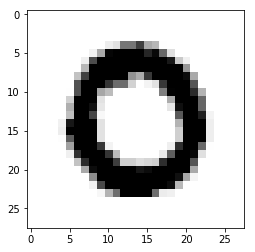

In [5]:
#### print one picture to see

image = train.iloc[1,1:].reshape((28,28))
print("this is a number ", train.iloc[1,0])
plt.imshow(image,cmap=plt.get_cmap('gray_r'))
plt.show()


In [7]:
## define train_x, train_y, test_y and normalization

train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]
train_x = train_x / 255
test_x = test / 255

In [8]:
### convet dataframe to array

train_x_array = np.asarray(train_x).reshape((42000,28,28,1)).astype("float32")
test_x_array = np.asarray(test_x).reshape((test_x.shape[0],28,28,1)).astype('float32')

In [9]:
### convert labels to onehot

def convert_one_hot(label):
    num_class = len(label.unique())
    zeros = np.zeros((label.shape[0],num_class))
    print(zeros.shape)
    for i in range(label.shape[0]):
        zeros[i,label.iloc[i]] =1
    return zeros

train_y_onehot = convert_one_hot(train_y)

(42000, 10)


In [10]:
##### components of CNN model

def create_placeholder(n_h,n_w,n_c0,n_y):
    
    X = tf.placeholder(tf.float32,shape=(None,n_h,n_w,n_c0))
    Y = tf.placeholder(tf.float32,shape=(None,n_y))
    
    return X,Y


def initialize_parameters():
    
    w1 = tf.get_variable(name="w1",shape=[3,3,1,5],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    w2 = tf.get_variable(name="w2",shape=[3,3,5,10],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    
    parameters = {"W1":w1,
                 "W2":w2}
    return parameters

def forward_propagation(X,parameters):
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")
    
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding="SAME")
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    P2 = tf.contrib.layers.flatten(P2)
    
    Z3 = tf.contrib.layers.fully_connected(P2,10,activation_fn=None)
    
    return Z3

def compute_cost(Z3,Y):
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    
    return cost

In [11]:
#### build a random minibatch function to help train the model

def random_minibatches(X,Y,minibatch_size,seed):
    
    np.random.seed(seed)
    m = X.shape[0]
    minibatches = []
    
    ### randomly shuffle X and Y
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation]
    shuffled_Y = Y[permutation]
    
    num_of_minibatches = math.floor(m / minibatch_size)
    
    for k in range(num_of_minibatches):
        minibatch_X = shuffled_X[k*minibatch_size:(k+1)*minibatch_size]
        minibatch_Y = shuffled_Y[k*minibatch_size:(k+1)*minibatch_size]
        minibatch = (minibatch_X,minibatch_Y)
        minibatches.append(minibatch)
    ### just in case last minibatch < minibatch size    
    if m % minibatch_size != 0:
        minibatch_X = shuffled_X[num_of_minibatches*minibatch_size:]
        minibatch_Y = shuffled_Y[num_of_minibatches*minibatch_size:]
        minibatch = (minibatch_X,minibatch_Y)
        minibatches.appened(minibatch)
        
    return minibatches
        

In [16]:
#### Build the CNN model with 2 hidden layers, filter_size: 3*3, strides:1, padding: "SAME"

def CNN_model(train_x,train_y,test_x,learning_rate,num_epochs ,minibatch_size ):
    
    seed = 2
    
    m = train_x.shape[0]
    n_h = train_x.shape[1]
    n_w = train_x.shape[2]
    n_c0 = train_x.shape[3]
    n_y = train_y.shape[1]
    costs = []
    
    X,Y = create_placeholder(n_h=n_h,n_w = n_w, n_c0 = n_c0,n_y=n_y)
    
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X=X,parameters=parameters)
    
    cost = compute_cost(Z3,Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate,name='Adam').minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            minibatch_cost = 0
            num_minibatches = int(m/minibatch_size)
            seed +=1
            minibatches = random_minibatches(train_x,train_y,minibatch_size,seed=1)
            
            for minibatch in minibatches:
                minibatch_x, minibatch_y = minibatch
                __, single_minibatch_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_x,Y:minibatch_y})
                
                minibatch_cost += single_minibatch_cost / num_minibatches
                
            costs.append(minibatch_cost)
            
            if epoch % 5 == 0:
                print("cost after {} epoches is {}".format(epoch+5,minibatch_cost))
                
        plt.plot(np.squeeze(costs))
        plt.title("cost under learningrate {}".format(learning_rate))
        plt.show()
        
        prediction = tf.argmax(Z3,1)
        correct_pred = tf.equal(prediction,tf.argmax(train_y,1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_pred,"float"))
        
        train_accuracy = accuracy.eval({X:train_x,Y:train_y})
        
        print("Train accuracy is {}".format(train_accuracy))
        
        prediction_test = sess.run(Z3,feed_dict={X:test_x})
        
        
        return train_accuracy,parameters,prediction_test
        

cost after 5 epoches is 0.5127373531758787
cost after 10 epoches is 0.08058171095140286
cost after 15 epoches is 0.05591723409667609
cost after 20 epoches is 0.04472549195936877
cost after 25 epoches is 0.03736767962493471
cost after 30 epoches is 0.03179449710622428
cost after 35 epoches is 0.027143164494365928
cost after 40 epoches is 0.023205307251890173
cost after 45 epoches is 0.019768581904820177
cost after 50 epoches is 0.01686093696462921
cost after 55 epoches is 0.015079857806827928
cost after 60 epoches is 0.013895185907203999
cost after 65 epoches is 0.012424930624976703
cost after 70 epoches is 0.011260944345862294
cost after 75 epoches is 0.009867733362043513
cost after 80 epoches is 0.008811976068704095
cost after 85 epoches is 0.00839133301324637
cost after 90 epoches is 0.008395456321259645
cost after 95 epoches is 0.005459954199624007
cost after 100 epoches is 0.00471581479811994


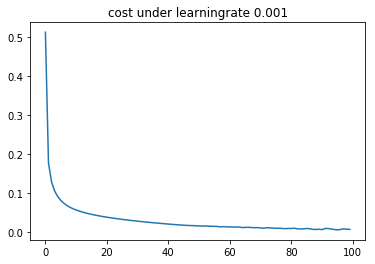

Train accuracy is 0.9955238103866577


In [17]:
#### Training 

tf.reset_default_graph()
learning_rate = 0.001
num_epochs = 100
minibatch_size = 84
__,parameters,prediction_test = CNN_model(train_x_array,train_y_onehot,test_x = test_x_array,learning_rate = learning_rate,num_epochs = num_epochs,minibatch_size=minibatch_size)

cost after 5 epoches is 0.40607751816883664
cost after 10 epoches is 0.06853347952454368
cost after 15 epoches is 0.04632280462820203
cost after 20 epoches is 0.03546010727880632
cost after 25 epoches is 0.02775753160688328
cost after 30 epoches is 0.021746906952674186
cost after 35 epoches is 0.017428906519283374
cost after 40 epoches is 0.014366341338925838
cost after 45 epoches is 0.012757809139171065
cost after 50 epoches is 0.011340676336447706
cost after 55 epoches is 0.011318166034059794
cost after 60 epoches is 0.007757737313580812
cost after 65 epoches is 0.007102672169678862
cost after 70 epoches is 0.006995585313971399
cost after 75 epoches is 0.007304335530583958
cost after 80 epoches is 0.0056889485789946735
cost after 85 epoches is 0.0060219500430559614
cost after 90 epoches is 0.004485797386147745
cost after 95 epoches is 0.0067674195649570995
cost after 100 epoches is 0.006418267373627104


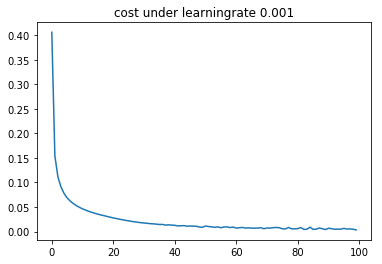

Train accuracy is 0.9959999918937683


In [18]:
#### change minibatch_size to 42 
tf.reset_default_graph()
learning_rate = 0.001
num_epochs = 100
minibatch_size = 42
__,parameters,prediction_test = CNN_model(train_x_array,train_y_onehot,test_x = test_x_array,learning_rate = learning_rate,num_epochs = num_epochs,minibatch_size=minibatch_size)


select 19159th image from training
predicted as 1


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


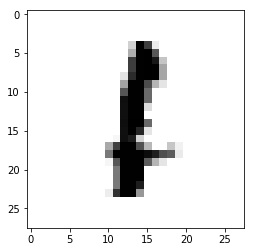

select 11023th image from training
predicted as 6


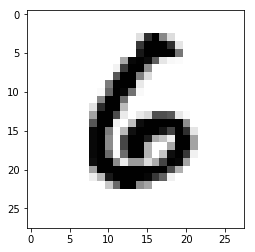

select 9303th image from training
predicted as 7


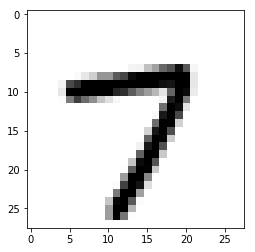

select 15713th image from training
predicted as 0


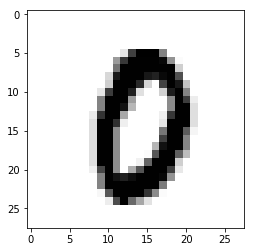

select 26429th image from training
predicted as 9


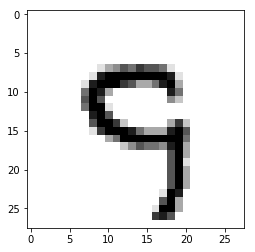

In [21]:
### randomly select 5 images from test set 

check_list = np.random.randint(0,28000, size=5)
prediction_test = np.argmax(prediction_test,axis=1)
for i in check_list:
    print("select {}th image from training".format(i))
    print("predicted as {}".format(prediction_test[i]))
    image = test.iloc[i].reshape((28,28))
    plt.imshow(image,cmap=plt.get_cmap('gray_r'))
    plt.show()